In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm
from lightgbm import LGBMRegressor
import optuna

## Data Load

In [3]:
path=""
users = pd.read_csv(path+'users_ppd_test.csv')
books = pd.read_csv(path+'books_ppd_test.csv')
train = pd.read_csv(path+'/train_ratings.csv')
test = pd.read_csv(path+'/test_ratings.csv')
sub = pd.read_csv(path+'/sample_submission.csv')

In [4]:
ids = pd.concat([train['user_id'], sub['user_id']]).unique()
isbns = pd.concat([train['isbn'], sub['isbn']]).unique()

idx2user = {idx:id for idx, id in enumerate(ids)}
idx2isbn = {idx:isbn for idx, isbn in enumerate(isbns)}

user2idx = {id:idx for idx, id in idx2user.items()}
isbn2idx = {isbn:idx for idx, isbn in idx2isbn.items()}

train['user_id'] = train['user_id'].map(user2idx)
test['user_id'] = test['user_id'].map(user2idx)
users['user_id'] = users['user_id'].map(user2idx)

train['isbn'] = train['isbn'].map(isbn2idx)
test['isbn'] = test['isbn'].map(isbn2idx)
books['isbn'] = books['isbn'].map(isbn2idx)

users=users.drop(['location' ,'location_state'], axis=1) 
books=books.drop(['img_url','img_path', 'summary', 'book_title'], axis=1)

train=train.merge(users, on="user_id", how="left").merge(books, on="isbn", how="left")
test=test.merge(users, on="user_id", how="left").merge(books, on="isbn", how="left")

train=train.drop(['user_id', 'isbn'], axis=1)
test=test.drop(['user_id', 'isbn'], axis=1)

for c in train.columns:
    if train[c].dtype == 'object':
        train[c] = train[c].astype('category')
for c in test.columns:
    if test[c].dtype == 'object':
        test[c] = test[c].astype('category')

data = {
    'train':train.drop(['rating'], axis=1), 
    'train_rate':train['rating'],
    'X_test':test.drop(['rating'], axis=1),
    }

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
                                                    data['train'],
                                                    data['train_rate'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True
                                                    )

## Model Train

/tmp/ipykernel_12352/3959762955.py:17: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-04-26 03:54:48,038] A new study created in memory with name: no-name-862b82cd-f9e2-416a-ac7c-a0c0f49d9ec6
[I 2023-04-26 03:54:48,039] Searching the best hyperparameters using 245436 samples...
[I 2023-04-26 03:55:01,469] Trial 5 finished with value: -1.857463368844281 and parameters: {'num_leaves': 68, 'learning_rate': 0.06817701076262304, 'subsample': 0.8909598655926363, 'colsample_bytree': 0.9671125511341574, 'reg_alpha': 0.9335252622463451, 'reg_lambda': 0.3784367583622473, 'min_child_samples': 366, 'n_estimators': 31, 'max_depth': 5}. Best is trial 5 with value: -1.857463368844281.
[I 2023-04-26 03:55:32,262] Trial 0 finished with value: -1.8489961759876743 and parameters: {'num_leaves': 56, 'learning_rate': 0.0432862828102993, 'subsample': 0.7141556394257917, 'colsam

best score: -1.8447489861795645
valid rmse :  1.8515926289573643


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

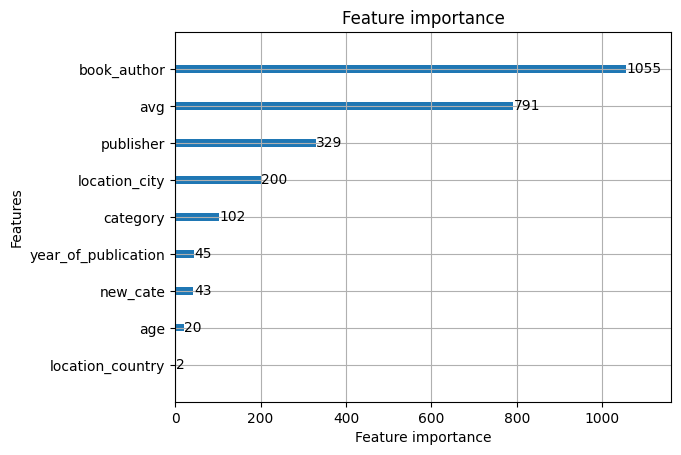

In [11]:
def rmse(real, predict):
            return np.sqrt(np.mean((real-predict) ** 2))
    
lgbm_params = {
                'objective': 'regression',
                'metric': 'rmse',
                'verbosity': -1,
                'boosting_type': 'gbdt',
                'subsample': 0.8,
                'learning_rate': 0.1,
                'num_leaves': 31,
                'n_estimators': 100,
                }

lgbm = LGBMRegressor(**lgbm_params) #Base Estimator

optuna_search = optuna.integration.OptunaSearchCV(
    estimator=lgbm,
    param_distributions={
        'num_leaves': optuna.distributions.IntDistribution(2, 100),
        'learning_rate': optuna.distributions.FloatDistribution(0.0001, 0.07),
        'subsample': optuna.distributions.FloatDistribution(0.5, 1),
        'colsample_bytree': optuna.distributions.FloatDistribution(0.5, 1),
        'reg_alpha': optuna.distributions.FloatDistribution(0, 1),
        'reg_lambda': optuna.distributions.FloatDistribution(0, 1),
        'min_child_samples': optuna.distributions.IntDistribution(10, 500),
        'n_estimators': optuna.distributions.IntDistribution(10, 500),
        'max_depth': optuna.distributions.IntDistribution(3, 10),
    },
    cv=5, n_jobs=-1, n_trials=15, verbose=2, random_state=42, scoring='neg_root_mean_squared_error')

optuna_search.fit(X_train, y_train)  

print("best score:", optuna_search.best_score_)
best_model = optuna_search.best_estimator_

#validation
y_pred = best_model.predict(X_valid)
print("valid rmse : ", rmse(y_pred, y_valid))

#feature importance
lightgbm.plot_importance(best_model)

## Predict

In [12]:
X_test = data['X_test']
predicts=best_model.predict(X_test)
sub['rating'] = predicts
sub.to_csv("LGBM_submission.csv", index=False)